<a href="https://colab.research.google.com/github/jackliusr/automatic-watermark-detection/blob/master/Watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Automatic watermark removal
This is the Jupyter notebook for automatic watermark removal code.
We follow the scripts till watermark estimation and then try to solve the watermarking problem.

https://github.com/jackliusr/automatic-watermark-detection

Works on None GPU and TPU

In [7]:
%matplotlib inline


from src import *

gx, gy, gxlist, gylist = estimate_watermark('./images/fotolia_processed')

est = poisson_reconstruct(gx, gy)
cropped_gx, cropped_gy = crop_watermark(gx, gy)
est2 = poisson_reconstruct(cropped_gx, cropped_gy)

# random photo
img = cv2.imread('./images/fotolia_processed/BUVH_14b.jpg')
im, start, end = watermark_detector(img, cropped_gx, cropped_gy)

# plt.imshow(im)
# plt.show()

Computing gradients.
Computing median gradients.


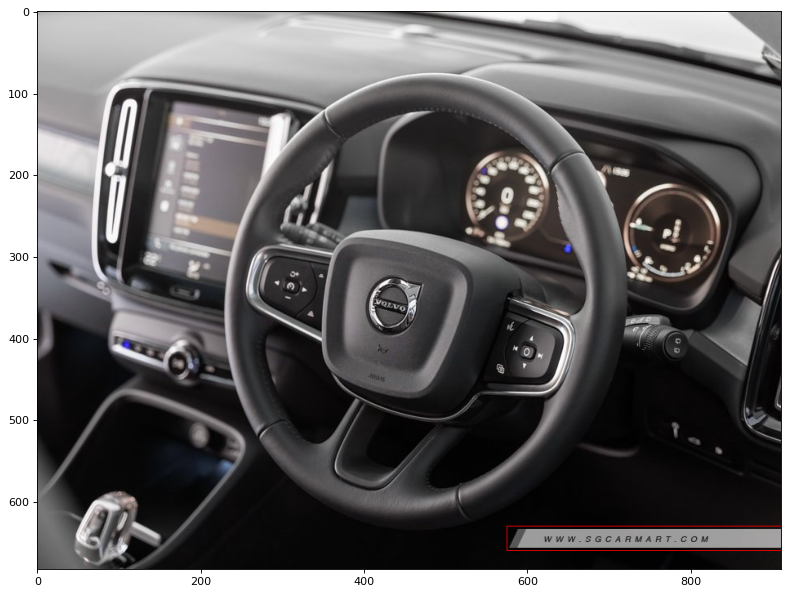

In [8]:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)

In [9]:
print(cropped_gx.shape, cropped_gy.shape, est.shape, est2.shape)
print(im.shape, start, end)

(30, 336, 3) (30, 336, 3) (683, 911, 3) (30, 336, 3)
(683, 911, 3) (630, 575) (30, 336)


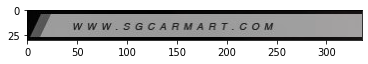

In [10]:
plt.imshow(img[start[0]:(start[0]+end[0]), start[1]:(start[1]+end[1]), :])

In [11]:
'''
This is the part where we get all the images, extract their parts, and then add it to our matrix
'''
num_images = len(gxlist)
images_cropped = np.zeros((num_images,) + cropped_gx.shape)

# get images
foldername = './images/fotolia_processed'

# Store all the watermarked images
# start, and end are already stored
# just crop and store image
image_paths = []
_s, _e = start, end
index = 0

# Iterate over all images
for r, dirs, files in os.walk(foldername):

    for file in files:
        _img = cv2.imread(os.sep.join([r, file]))
        if _img is not None:
            # estimate the watermark part
            image_paths.append(os.sep.join([r, file]))
            _img = _img[_s[0]:(_s[0]+_e[0]), _s[1]:(_s[1]+_e[1]), :]
            # add to list images
            images_cropped[index, :, :, :] = _img
            index+=1
        else:
            print("%s not found."%(file))
            
print("done")

done


65


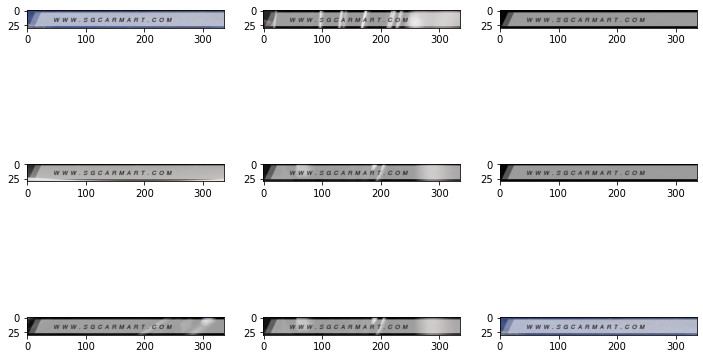

In [12]:
# Print some random indices extracted
print(index)
N = 3
random_indices = np.random.randint(9, size=(N*N,))
fig, axes = plt.subplots(N, N, figsize=(12, 8))
for i, val in enumerate(random_indices):
    axes[int(i/N), int(i%N)].imshow(images_cropped[val].astype('uint8'))

### Image reconstruction
Here comes the tougher part. We have an initial estimate for the watermark `Wm, cropped_gx, cropped_gy` and `est`. Using this, we solve the problem of Multi-image matting and reconstruction. We have a list of images, `images_cropped`, and we have to estimate `W` and `alpha` by reiterating the following 3 steps: 
- Image-Watermark detection
- Watermark update
- Matte update

Finally, we do a Matte and blend factor initialization to determine the constant and normalized matte.

In [13]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()


2.4.1


In [14]:
tf.compat.v1.disable_v2_behavior()
# helpers that are going to be useful here
sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], tf.float32)
sobel_y = tf.transpose(sobel_x)

sobel_x_filter = tf.stack([sobel_x, sobel_x, sobel_x])
sobel_x_filter = tf.stack([sobel_x_filter, sobel_x_filter, sobel_x_filter])

sobel_y_filter = tf.stack([sobel_y, sobel_y, sobel_y])
sobel_y_filter = tf.stack([sobel_y_filter, sobel_y_filter, sobel_y_filter])

def phi_func(mtensor, epsilon=0.001):
    return tf.sqrt(mtensor + epsilon**2)
    
# E_data
def E_data(I, W, J, alpha):
    est_error = tf.multiply(alpha, W) + tf.multiply(1-alpha, I) - J
    est_error = phi_func(tf.square(est_error))
    est_error = tf.reduce_sum(est_error)
    return est_error

# regularizer term for I, W
def E_reg(I, alpha):
    alpha_ = tf.expand_dims(alpha, 0)
    ax = tf.nn.conv2d(alpha_, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    ay = tf.nn.conv2d(alpha_, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    Ix2 = tf.square(tf.nn.conv2d(I, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME"))
    Iy2 = tf.square(tf.nn.conv2d(I, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME"))
    est_error = tf.multiply(tf.abs(ax), Ix2) + tf.multiply(tf.abs(ay), Iy2)
    est_error = tf.reduce_sum(phi_func(est_error))
    return est_error

# regularization term for alpha
def E_reg_alpha(alpha):
    alpha_ = tf.expand_dims(alpha, 0)
    ax2 = tf.square(tf.nn.conv2d(alpha_, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME"))
    ay2 = tf.square(tf.nn.conv2d(alpha_, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME"))
    est_error = tf.reduce_sum(phi_func(ax2 + ay2))
    return est_error

# fidelity term
# W = all watermarks
def E_f(alpha, W, W_m):
    aW = tf.multiply(alpha, W)
    # find edge map of alpha*W
    aWx = tf.nn.conv2d(aW, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    aWy = tf.nn.conv2d(aW, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    aW_ = tf.sqrt(tf.square(aWx) + tf.square(aWy))
    
    # find edge map of W_m
    W_m__ = tf.expand_dims(W_m, 0)
    W_mx = tf.nn.conv2d(W_m__, sobel_x_filter, strides=[1, 1, 1, 1], padding="SAME")
    W_my = tf.nn.conv2d(W_m__, sobel_y_filter, strides=[1, 1, 1, 1], padding="SAME")
    W_m_ = tf.sqrt(tf.square(W_mx) + tf.square(W_my))
    
    return tf.reduce_sum(phi_func(tf.square(aW_ - W_m_)))

# auxiliary term
def E_aux(W, W_k):
    return tf.reduce_sum(tf.abs(W - W_k))


# We try to use Tensorflow to perform the 3 steps
def image_watermark_decompose_model(num_images, m, n, chan=3, l_i=1, l_w=1, l_alpha=1, beta=1, gamma=1):
    # We have the following parameters
    # num_images = number of images, m, n, number of channels
    # lambda_i, lambda_w, lambda_alpha, beta, and gamma are parameters
    # Input to network: 
    #    J(k) = (num_images, m, n, chan) -> all the images
    #    W_m = (m, n, chan)   -> estimate of the watermark obtained before
    #    W_median =   (m, n, chan)   -> new estimate of W
    #    alpha = (m, n, chan) -> estimate of alpha matte
    # Entities to estimate
    #    I(k) = (num_images, m, n, chan) -> all watermarked images
    #    W(k) = (num_images, m, n, chan) -> all watermarks
    
    # All placeholders
    J = tf.compat.v1.placeholder(tf.float32, shape=(num_images, m, n, chan), name='J' )
    alpha = tf.compat.v1.placeholder(dtype=tf.float32, shape=(m, n, chan), name='alpha')
    W_m = tf.compat.v1.placeholder(dtype=tf.float32, shape=(m, n, chan), name='W_m')
    W_median = tf.compat.v1.placeholder(dtype=tf.float32, shape=(m, n, chan), name='W_median')
    
    # All variables
    I = tf.Variable(np.random.randn(num_images, m, n, chan), name='I', dtype=tf.float32)
    W = tf.Variable(np.random.randn(num_images, m, n, chan), name='W', dtype=tf.float32)
    
    # compute loss
    loss = E_data(I, W, J, alpha) + l_i*E_reg(I, alpha) + l_w*E_reg(W, alpha) \
            + beta*E_f(alpha, W, W_m) + gamma*E_aux(W_median, W)
    
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.07).minimize(loss)
    return {
        'J': J,
        'alpha': alpha,
        'W_m': W_m,
        'W_median': W_median, 
        'I': I,
        'W': W,
        'loss': loss,
        'step': optimizer,
    }
    
    

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
num_images, m, n, chan = images_cropped.shape
model = image_watermark_decompose_model(num_images, m, n, chan)
print(model)

{'J': <tf.Tensor 'J:0' shape=(65, 30, 336, 3) dtype=float32>, 'alpha': <tf.Tensor 'alpha:0' shape=(30, 336, 3) dtype=float32>, 'W_m': <tf.Tensor 'W_m:0' shape=(30, 336, 3) dtype=float32>, 'W_median': <tf.Tensor 'W_median:0' shape=(30, 336, 3) dtype=float32>, 'I': <tf.Variable 'I:0' shape=(65, 30, 336, 3) dtype=float32>, 'W': <tf.Variable 'W:0' shape=(65, 30, 336, 3) dtype=float32>, 'loss': <tf.Tensor 'add_12:0' shape=() dtype=float32>, 'step': <tf.Operation 'GradientDescent' type=NoOp>}


In [18]:
# define the variables
# plt.imshow(PlotImage(est2))
W_m = est2
J = images_cropped
I = np.random.randn(num_images, m, n, chan)
alpha = np.random.rand(m, n, chan)
W_median = W_m.copy()
W = np.stack([W_m for _ in range(num_images)])
print
saver = tf.compat.v1.train.Saver()
init = tf.compat.v1.global_variables_initializer()
print("Start to training ...")
with tf.compat.v1.Session() as sess:
    init.run()
    for i in range(100):
        
        _, loss = sess.run([model['step'], model['loss']], feed_dict={
            model['J']: J,
            model['alpha']: alpha,
            model['W_m']: W_m,
            model['W_median']: W_median,
        })
        # print(loss)
    
print("end training ...")

Start to training ...
end training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


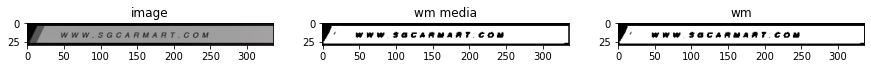

In [23]:
fig, ax= plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(img[start[0]:(start[0]+end[0]), start[1]:(start[1]+end[1]), :])
ax[0].set_title("image")
ax[1].imshow(W_median)
ax[1].set_title("wm media")
ax[2].imshow(W_m)
ax[2].set_title("wm")
plt.show()